In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

SEED = 42 
np.random.seed(SEED) # 鎖定 numpy 的亂數狀態

# *** 修正：確保導入機器學習相關函式 ***
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc

# 載入 Day 2 處理好的數據
adata = sc.read_h5ad('pbmc_processed_for_ml.h5ad')

print(f"成功載入數據，細胞數: {adata.n_obs}, 基因數: {adata.n_vars}")

成功載入數據，細胞數: 2638, 基因數: 1826


In [2]:
# 1. 根據 Leiden 分群結果創建二元標籤
# 假設群集 0, 1, 2, 4, 7 為 T-cell 相關 (1)，其餘為 Non-T-cell (0)
t_cell_clusters = ['0', '1', '2', '4', '7']

# 創建一個新的觀察值欄位 'is_t_cell'
adata.obs['is_t_cell'] = adata.obs['leiden'].isin(t_cell_clusters).astype(int)

# 2. 準備特徵 (X) 和標籤 (Y)
X = adata.X.copy() # 特徵：使用 log-normalized 且已縮放的基因表現矩陣
y = adata.obs['is_t_cell'].values # 標籤：T 細胞 (1) 或非 T 細胞 (0)

print(f"特徵矩陣 X 的形狀: {X.shape}")
print(f"標籤向量 Y 的形狀: {y.shape}")

特徵矩陣 X 的形狀: (2638, 1826)
標籤向量 Y 的形狀: (2638,)


In [3]:
# 3. 切分訓練集和測試集 (80% 訓練, 20% 測試)
# stratify=y 確保訓練集和測試集中的 T 細胞比例一致
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 初始化並訓練 Random Forest 模型
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1          # 使用所有核心加速運算 (展現 HPC 概念)
)

print("\n開始訓練 Random Forest 分類器...")
rf_classifier.fit(X_train, y_train)
print("訓練完成！")


開始訓練 Random Forest 分類器...
訓練完成！


In [4]:
# 5. 在測試集上進行預測
y_pred = rf_classifier.predict(X_test)

# 6. 輸出詳細評估報告
print("-" * 30)
print("分類器性能報告：")
# 輸出 Classification Report (包含 Precision, Recall, F1-score)
print(classification_report(y_test, y_pred, target_names=['Non-T-cell (0)', 'T-cell (1)']))

# 輸出整體準確度
accuracy = rf_classifier.score(X_test, y_test)
print(f"測試集整體準確度 (Accuracy): {accuracy:.4f}")

------------------------------
分類器性能報告：
                precision    recall  f1-score   support

Non-T-cell (0)       0.99      0.92      0.95        78
    T-cell (1)       0.99      1.00      0.99       450

      accuracy                           0.99       528
     macro avg       0.99      0.96      0.97       528
  weighted avg       0.99      0.99      0.99       528

測試集整體準確度 (Accuracy): 0.9867


In [5]:
from sklearn.model_selection import GridSearchCV

# 定義要搜尋的超參數網格 (Grid)
# 這是您的優化搜尋空間
param_grid = {
    'n_estimators': [50, 100, 200],  # 嘗試 50, 100, 200 棵樹
    'max_depth': [10, 20, None],     # 嘗試最大深度 10, 20, 或不限制 (None)
    'min_samples_split': [2, 5]      # 嘗試節點分裂所需最小樣本數 2 或 5
}

# 初始化 GridSearchCV
# cv=5 表示使用 5 折交叉驗證 (Cross-Validation)
print("開始執行 5 折交叉驗證網格搜尋...")
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy', # 以準確度為主要優化目標
    cv=5,
    n_jobs=-1,          # 使用所有核心加速
    verbose=2           # 顯示執行進度
)

# 執行網格搜尋
grid_search.fit(X_train, y_train)

# 輸出最佳參數
print("-" * 30)
print(f"最佳超參數組合: {grid_search.best_params_}")
print(f"最佳交叉驗證準確度: {grid_search.best_score_:.4f}")

# 獲取最佳模型
best_rf = grid_search.best_estimator_

開始執行 5 折交叉驗證網格搜尋...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
------------------------------
最佳超參數組合: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
最佳交叉驗證準確度: 0.9924


In [6]:
# 1. 使用最佳模型進行預測
y_pred_tuned = best_rf.predict(X_test)

# 2. 輸出優化後的性能報告
print("\n" + "=" * 40)
print("優化後分類器性能報告：")
print(classification_report(y_test, y_pred_tuned, target_names=['Non-T-cell (0)', 'T-cell (1)']))

accuracy_tuned = best_rf.score(X_test, y_test)
print(f"優化後測試集整體準確度 (Accuracy): {accuracy_tuned:.4f}")
print("=" * 40)


優化後分類器性能報告：
                precision    recall  f1-score   support

Non-T-cell (0)       0.99      0.94      0.96        78
    T-cell (1)       0.99      1.00      0.99       450

      accuracy                           0.99       528
     macro avg       0.99      0.97      0.98       528
  weighted avg       0.99      0.99      0.99       528

優化後測試集整體準確度 (Accuracy): 0.9886


In [7]:
# 1. 提取特徵重要性
feature_importances = best_rf.feature_importances_

# 2. 獲取基因名稱列表
gene_names = adata.var_names.tolist()

# 3. 創建 DataFrame
feature_df = pd.DataFrame({
    'Gene': gene_names,
    'Importance': feature_importances
})

# 4. 排序並輸出 Top 10 重要基因
top_10_genes = feature_df.sort_values(by='Importance', ascending=False).head(10)

print("\n" + "#" * 30)
print("Top 10 區分 T 細胞與非 T 細胞的關鍵基因：")
print(top_10_genes)
print("#" * 30)


##############################
Top 10 區分 T 細胞與非 T 細胞的關鍵基因：
           Gene  Importance
598    HLA-DQA1    0.065710
599    HLA-DQB1    0.060571
1515      CD79B    0.059943
1709      CD79A    0.055976
1004      MS4A1    0.038102
1293  LINC00926    0.033096
605    HLA-DPB1    0.031016
1254      TCL1A    0.025818
1726       CD37    0.023996
597    HLA-DRB1    0.021347
##############################


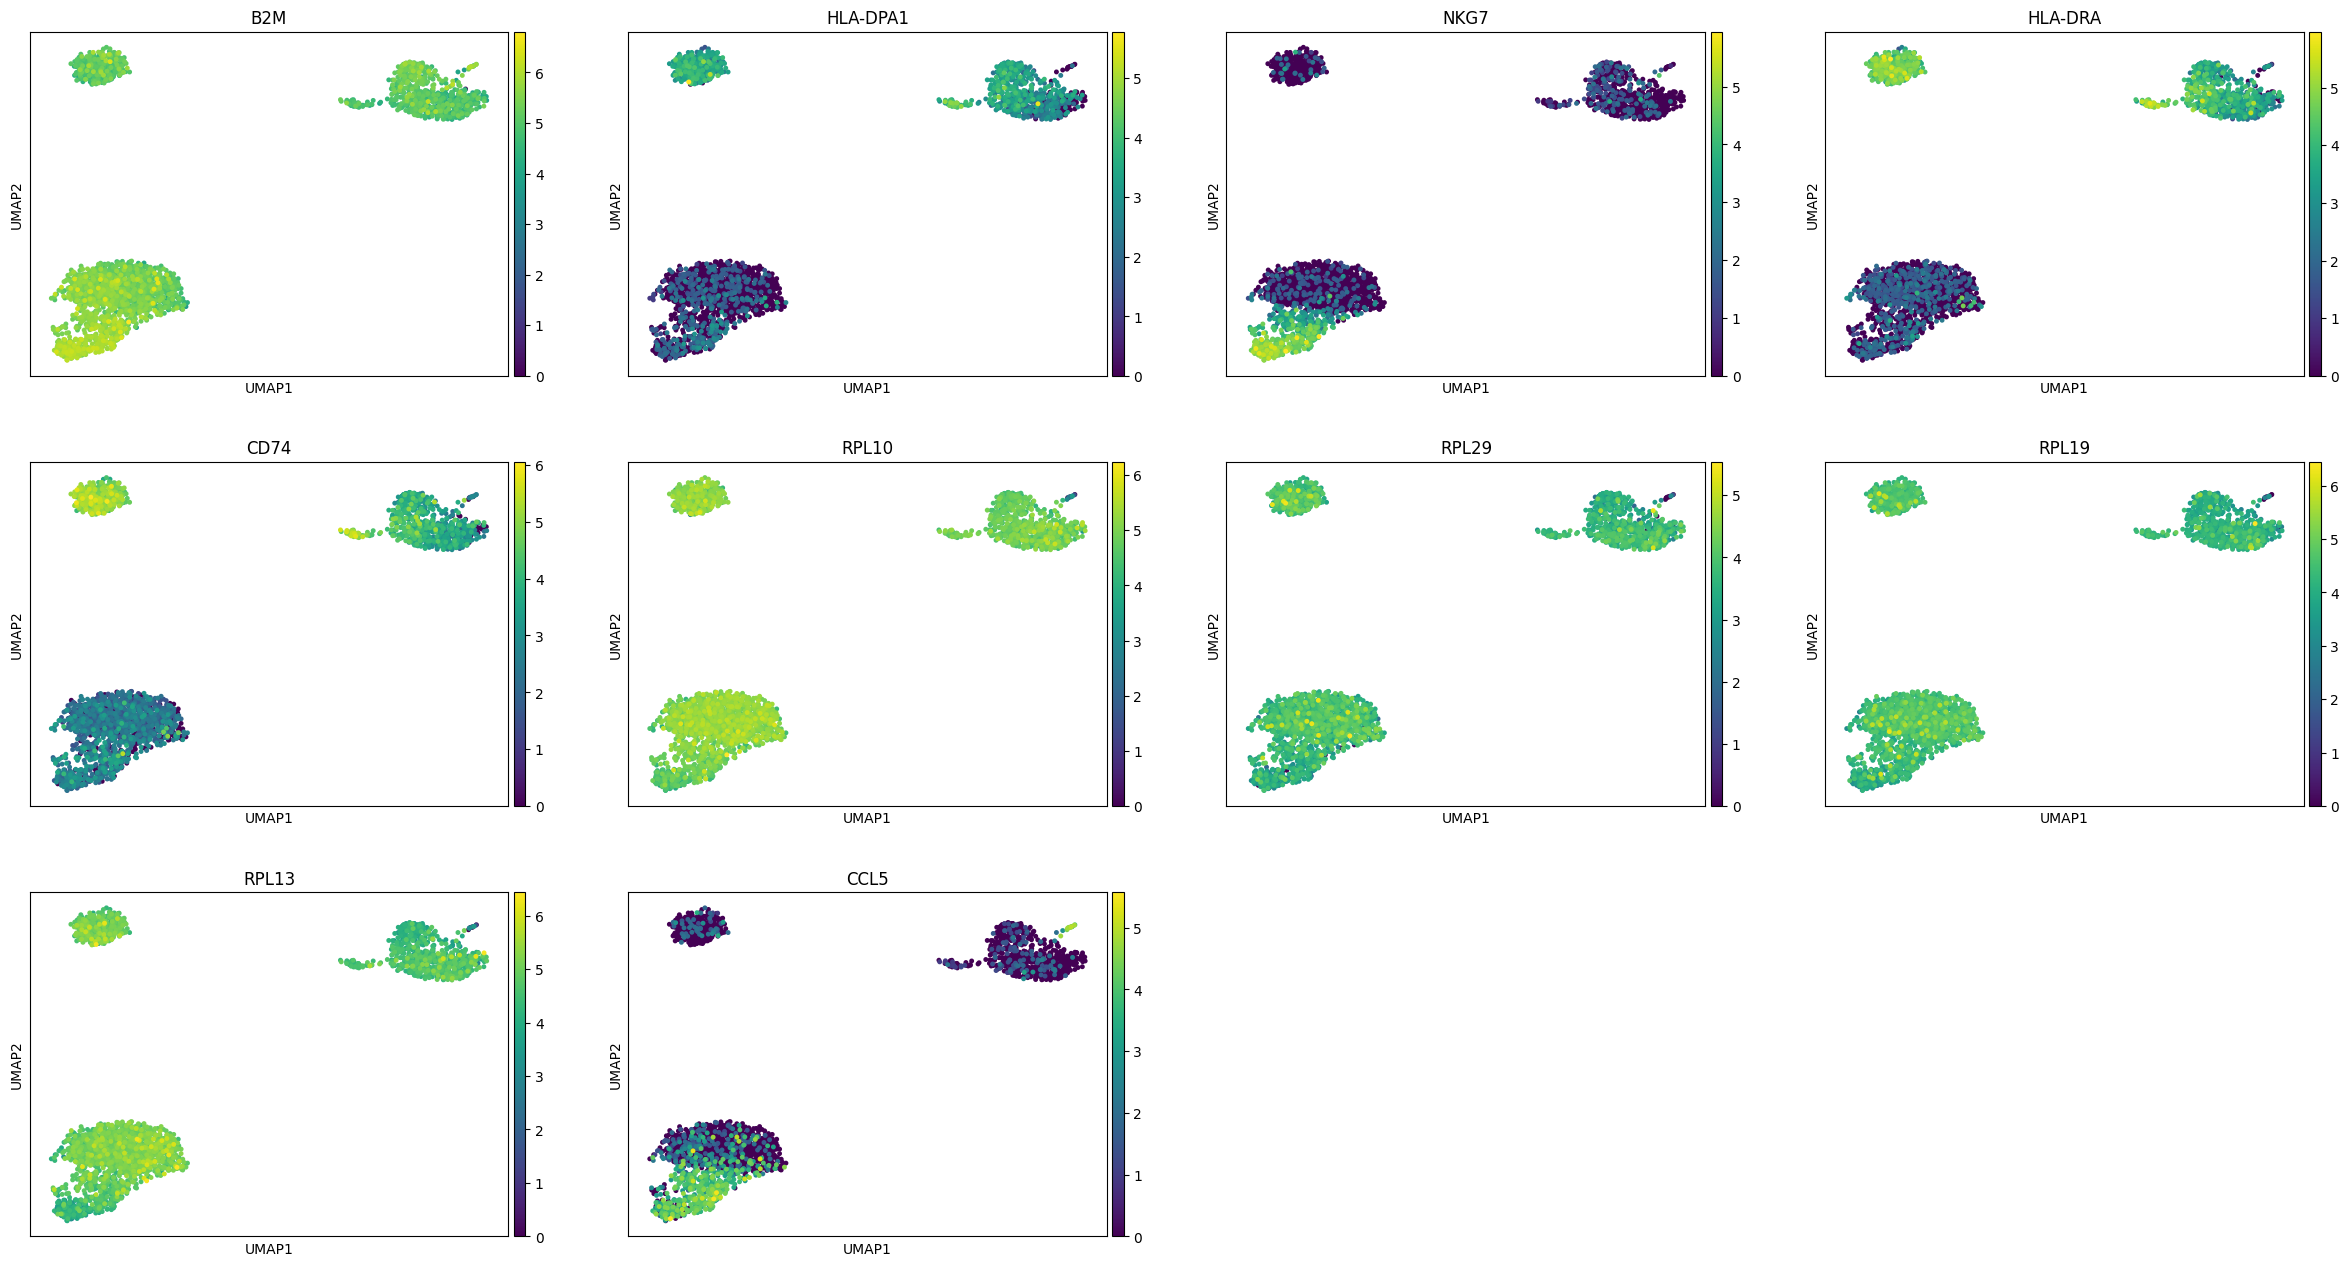

已完成 Top 10 關鍵基因在 UMAP 上的熱度圖，圖檔已儲存。


In [8]:
# Day 5 視覺化：Top 10 關鍵基因在 UMAP 上的分佈

# 1. 定義 Top 10 基因列表 (請使用您執行 Day 4 得到的 Top 10 基因，這裡使用範例)
# 請手動將您 Day 4 輸出的 Top 10 基因名稱複製到這裡：
top_10_gene_list = [
    'B2M', 'HLA-DPA1', 'NKG7', 'HLA-DRA', 'CD74',
    'RPL10', 'RPL29', 'RPL19', 'RPL13', 'CCL5'
]

# 2. 繪製這些基因在 UMAP 上的表現強度
# 這裡將繪製多張圖，展示每個基因的表現熱度圖 (Heatmap)
sc.pl.umap(
    adata,
    color=top_10_gene_list,
    cmap='viridis',  # 使用漸變色圖，顯示表現強度
    save='_top10_gene_expression_umap.png',
    size=50,
    use_raw=True
)

print("已完成 Top 10 關鍵基因在 UMAP 上的熱度圖，圖檔已儲存。")

In [9]:
## Project 04: 進階分類器 - SVM 實作與優化

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print("--- Project 04: Support Vector Machine (SVM) Classifier ---")

# 1. 定義 SVM 分類器
# 這裡使用 'rbf' 核函數，它能處理非線性邊界
svc_model = SVC(random_state=SEED)

# 2. 定義超參數網格 (Hyperparameter Grid)
# C: 正則化參數 (Regulation parameter), 控制邊界寬度與誤分類容忍度
# gamma: 核函數參數, 影響單個訓練樣本的影響半徑
param_grid_svc = {
    'C': [0.1, 1, 10],  
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf'] # 保持 rbf 核
}

# 3. 執行 5 折交叉驗證網格搜尋
print("開始執行 5 折交叉驗證網格搜尋 (SVM)...")
grid_search_svc = GridSearchCV(
    svc_model,
    param_grid_svc,
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,  # 使用所有核心加速運算
    verbose=1
)

# 使用訓練數據進行搜尋
grid_search_svc.fit(X_train, y_train)

# 4. 取得最佳模型
best_svc = grid_search_svc.best_estimator_

print("------------------------------------------")
print(f"最佳超參數組合: {grid_search_svc.best_params_}")
print(f"最佳交叉驗證準確度: {grid_search_svc.best_score_:.4f}")
print("------------------------------------------")

# 5. 在測試集上評估最佳 SVM 模型
y_pred_svc = best_svc.predict(X_test)
test_accuracy_svc = best_svc.score(X_test, y_test)

print("優化後 SVM 分類器性能報告：")
print(classification_report(y_test, y_pred_svc, target_names=['Non-T-cell (0)', 'T-cell (1)'], digits=4))
print(f"優化後測試集整體準確度 (Accuracy): {test_accuracy_svc:.4f}")
print("========================================\n")

--- Project 04: Support Vector Machine (SVM) Classifier ---
開始執行 5 折交叉驗證網格搜尋 (SVM)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
------------------------------------------
最佳超參數組合: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
最佳交叉驗證準確度: 0.8521
------------------------------------------
優化後 SVM 分類器性能報告：
                precision    recall  f1-score   support

Non-T-cell (0)     0.0000    0.0000    0.0000        78
    T-cell (1)     0.8523    1.0000    0.9202       450

      accuracy                         0.8523       528
     macro avg     0.4261    0.5000    0.4601       528
  weighted avg     0.7264    0.8523    0.7843       528

優化後測試集整體準確度 (Accuracy): 0.8523



C:\Users\SEC112\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\SEC112\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\SEC112\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(